In [58]:
import os
import gc
import re

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import wordcloud

from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [59]:
# !pip install pyarrow
# !pip install nltk
# !pip install wordcloud
# !pip install xgboost
# !pip install scikit-learn

In [60]:
# train = pd.read_csv('c:/data/project/train.csv')
# test = pd.read_csv('c:/data/project/test.csv')

## Data Preprocessing

In [61]:
# # parquet으로 저장 함수, csv보다 매우 빠르게 데이터 처리가 가능:)
## Convert CSV files to Parquet format for faster data reading and processing
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()                            #garbage collect
    print(save_name, 'Done.')

In [62]:
csv_to_parquet('c:/data/project/train.csv', 'train')
csv_to_parquet('c:/data/project/test.csv', 'test')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
# sample_submission = pd.read_csv('c:/data/project/sample_submission.csv', index_col = 0)

train Done.
test Done.


In [63]:
# train 복사
train1 = train.copy()
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


In [64]:
train1.drop(columns=['ID','first_party', 'second_party'], inplace=True)

In [65]:
print(train1['first_party_winner'].value_counts())
train1.head()

first_party_winner
1    1649
0     829
Name: count, dtype: int64


,facts,first_party_winner
0,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,"On April 24, 1953 in Selma, Alabama, an intrud...",1


## 자연어처리

In [66]:
train_target = pd.DataFrame(train1, columns=['first_party_winner'])
df_nlp = pd.DataFrame(train1[['facts']], columns=['facts'])

# df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True) # 특수문자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'\d', '', regex=True)       # 숫자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'[^\w\s]', '', regex=True)

# display(df_nlp, train_target)
df_nlp['facts'].head()

0    On June   Phil St Amant a candidate for public...
1    Ramon Nelson was riding his bike when he suffe...
2    An Alabama state court convicted Billy Joe Mag...
3    Victor Linkletter was convicted in state court...
4    On April   in Selma Alabama an intruder broke ...
Name: facts, dtype: object

In [67]:
train_target.value_counts()

first_party_winner
1                     1649
0                      829
Name: count, dtype: int64

In [68]:
# import nltk
# nltk.download()

In [69]:
# from nltk.tokenize import WhitespaceTokenizer
# # 공백 단위로 쪼개기
# corpus = df_nlp1["facts"]
# Tokenizer=WhitespaceTokenizer()
# lst_tokens = Tokenizer.tokenize(str(corpus))
# lst_tokens

## 사용자 불용어 + 기본 제공 불용어 생성

In [70]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, user_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
        
    if user_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    user_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [71]:
# 사용자 불용어 제작
user_stopwords = set(["appeal","filed","affirmed","held","u","state","supreme","federal","circuit","district", "law", "court", "case", "plaintiff", "defendant",
                "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding",
                "litigation", "party", "motion", "action", "suit", "claim", "issue",
                "fact", "hearing", "judgment", "order", "allegation", "argument",
                "brief", "charge", "complaint", "contract", "crime", "decision", "defense",
                "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal",
                "liability", "matter", "notice", "opinion", "plea", "point", "policy", "practice",
                "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict",
                'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph"
                "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation",
                "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty",
                "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal",
                "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation",
                "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule",
                "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment",
                "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal",
                "bail", "contempt", "conviction", "felony", "parole", "sentence",
                "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor",
                "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor",
                "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer",
                "insured", "beneficiary", "fiduciary", "principal", "agent"])

In [72]:
# NLTK가 제공 기본 불용어
lst_stopwords = nltk.corpus.stopwords.words("english")

In [73]:
len(user_stopwords)

153

In [74]:
train_nlp = df_nlp.join(train_target)
train_nlp

,facts,first_party_winner
0,On June Phil St Amant a candidate for public...,1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,On April in Selma Alabama an intruder broke ...,1
...,...,...
2473,Congress amended the Clean Air Act through the...,1
2474,Alliance Bond Fund Inc an investment fund purc...,1
2475,In the District Court sentenced Manuel D Pegu...,0
2476,On March Enrico St Cyr a lawful permanent re...,0


## Tokenizing

In [75]:
def freq(data, columns):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    # wdTmp = utils_preprocess_text(temp, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords)
    

    ## unigrams
    fig, ax = plt.subplots(1, 1)
    fig.suptitle("Most frequent words", fontsize=15)
    figure(figsize=(30, 24))
    
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
    
    dtf_uni.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                        kind="barh", title="Unigrams", ax=ax, 
                        legend=False).grid(axis='x')

    ax.set(ylabel=None)
    plt.show()

    return [dic_words_freq, dtf_uni]

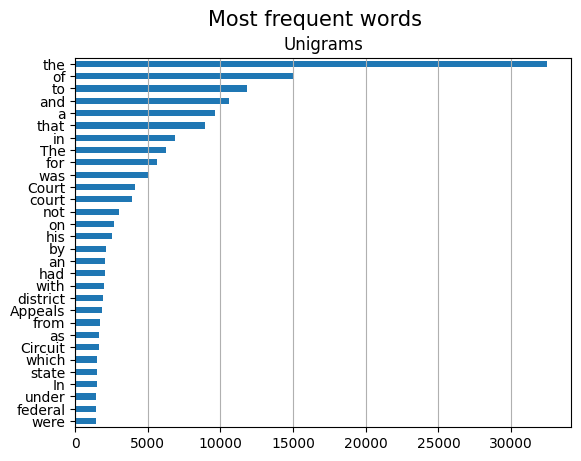

<Figure size 3000x2400 with 0 Axes>

FreqDist({'the': 32504, 'of': 15052, 'to': 11804, 'and': 10565, 'a': 9615, 'that': 8970, 'in': 6862, 'The': 6279, 'for': 5635, 'was': 5012, ...})

In [76]:
freq(train_nlp, 'facts')[0]

In [77]:
train_nlp

,facts,first_party_winner
0,On June Phil St Amant a candidate for public...,1
1,Ramon Nelson was riding his bike when he suffe...,0
2,An Alabama state court convicted Billy Joe Mag...,1
3,Victor Linkletter was convicted in state court...,0
4,On April in Selma Alabama an intruder broke ...,1
...,...,...
2473,Congress amended the Clean Air Act through the...,1
2474,Alliance Bond Fund Inc an investment fund purc...,1
2475,In the District Court sentenced Manuel D Pegu...,0
2476,On March Enrico St Cyr a lawful permanent re...,0


In [78]:
train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
train_nlp

,facts,first_party_winner
0,june phil st amant candidate public office mad...,1
1,ramon nelson riding bike suffered lethal blow ...,0
2,alabama state court convicted billy joe magwoo...,1
3,victor linkletter convicted state court eviden...,0
4,april selma alabama intruder broke apartment d...,1
...,...,...
2473,congress amended clean air act energy policy a...,1
2474,alliance bond fund inc investment fund purchas...,1
2475,district court sentenced manuel peguero month ...,0
2476,march enrico st cyr lawful permanent resident ...,0


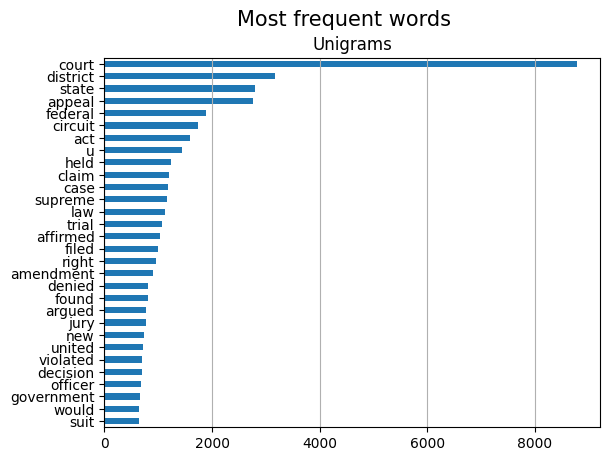

<Figure size 3000x2400 with 0 Axes>

[FreqDist({'court': 8776, 'district': 3168, 'state': 2793, 'appeal': 2757, 'federal': 1886, 'circuit': 1742, 'act': 1588, 'u': 1446, 'held': 1230, 'claim': 1206, ...}),
             Word  Freq
 0          court  8776
 1       district  3168
 2          state  2793
 3         appeal  2757
 4        federal  1886
 ...          ...   ...
 16873   patentee     1
 16874   localize     1
 16875   spurious     1
 16876   barcoded     1
 16877  westviews     1
 
 [16878 rows x 2 columns]]

In [79]:
freq(train_nlp, 'facts')

## N회 미만 불용어 추가

In [80]:
def func_stopwords(wht):
    wl_words=[]
    for word, freq in wht.most_common():
        if freq == 1:
            wl_words.append(word)
        user_stopwords.update(wl_words)
    return user_stopwords

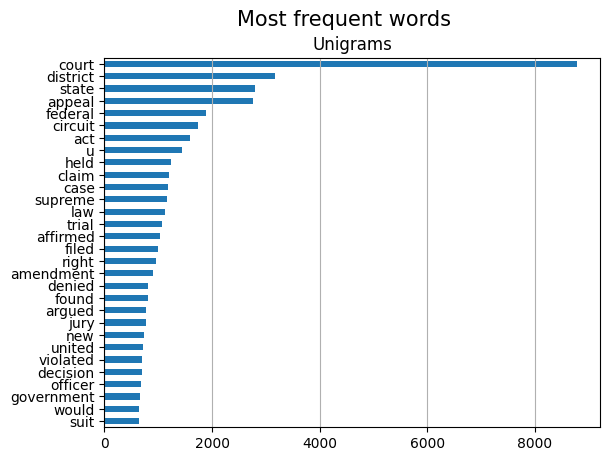

<Figure size 3000x2400 with 0 Axes>

In [81]:
real_freq, _ = freq(train_nlp, 'facts')

user_stopwords=func_stopwords(real_freq)

In [82]:
len(user_stopwords)

6207

In [83]:
train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
train_nlp

,facts,first_party_winner
0,june phil st amant candidate public office mad...,1
1,ramon nelson riding suffered lethal blow back ...,0
2,alabama convicted billy joe magwood murder sen...,1
3,victor linkletter convicted illegally obtained...,0
4,april selma alabama intruder broke apartment d...,1
...,...,...
2473,congress amended clean air energy effort reduc...,1
2474,alliance bond fund inc investment fund purchas...,1
2475,sentenced manuel peguero month imprisonment pl...,0
2476,march st cyr lawful permanent resident pled gu...,0


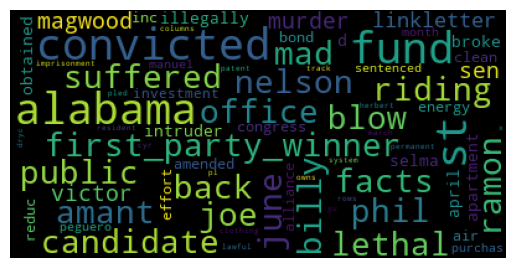

In [84]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                        max_font_size=35)
wc = wc.generate(str(train_nlp))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [85]:
train_nlp["first_party_winner"].value_counts()

first_party_winner
1    1649
0     829
Name: count, dtype: int64

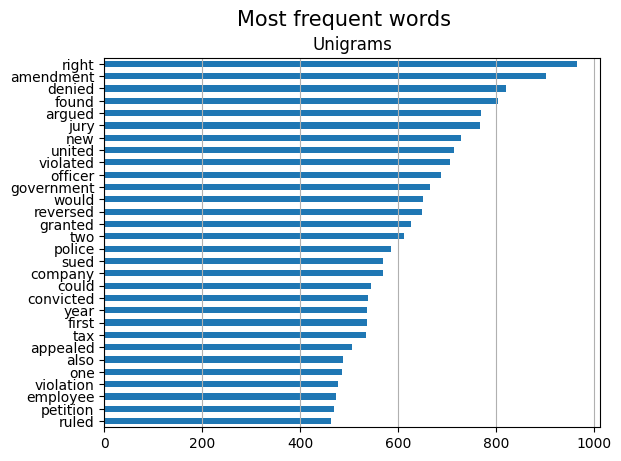

<Figure size 3000x2400 with 0 Axes>

[FreqDist({'right': 964, 'amendment': 901, 'denied': 819, 'found': 804, 'argued': 769, 'jury': 766, 'new': 728, 'united': 713, 'violated': 705, 'officer': 688, ...}),
               Word  Freq
 0            right   964
 1        amendment   901
 2           denied   819
 3            found   804
 4           argued   769
 ...            ...   ...
 10661  drycleaning     2
 10662     keyboard     2
 10663      optical     2
 10664     markmans     2
 10665     westview     2
 
 [10666 rows x 2 columns]]

In [86]:
freq(train_nlp, "facts")

## Preprocessing ENDS && MODELING STARTS

In [87]:
train_nlp = pd.concat([train_nlp,train['first_party'],train['second_party']],axis=1, join='inner')
train_nlp

,facts,first_party_winner,first_party,second_party
0,june phil st amant candidate public office mad...,1,Phil A. St. Amant,Herman A. Thompson
1,ramon nelson riding suffered lethal blow back ...,0,Stephen Duncan,Lawrence Owens
2,alabama convicted billy joe magwood murder sen...,1,Billy Joe Magwood,"Tony Patterson, Warden, et al."
3,victor linkletter convicted illegally obtained...,0,Linkletter,Walker
4,april selma alabama intruder broke apartment d...,1,William Earl Fikes,Alabama
...,...,...,...,...
2473,congress amended clean air energy effort reduc...,1,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al."
2474,alliance bond fund inc investment fund purchas...,1,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc."
2475,sentenced manuel peguero month imprisonment pl...,0,Peguero,United States
2476,march st cyr lawful permanent resident pled gu...,0,Immigration and Naturalization Service,St. Cyr


In [88]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['facts'])
    X_party2 = vectorizer.transform(df['facts'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

X = get_vector(vectorizer, train_nlp, True)
ylabel = train_nlp["first_party_winner"]

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X, ylabel, test_size=0.25, random_state=11)
X_train

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

#LogisticsREGRESSION

In [90]:
lr = LogisticRegression(solver='liblinear', class_weight = 'balanced')
scores = cross_val_score(lr, np.asarray(X_train), y_train, cv=5)
print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Cross-validation scores:  [0.58870968 0.63709677 0.61290323 0.59299191 0.61994609]
Average cross-validation score:  0.6103295365620381


In [91]:
lr.fit(np.asarray(X_train), y_train)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [92]:
print("LR Accuracy : %f" % lr.score(np.asarray(X_eval), y_eval))

LR Accuracy : 0.567742


In [93]:
print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Cross-validation scores:  [0.58870968 0.63709677 0.61290323 0.59299191 0.61994609]
Average cross-validation score:  0.6103295365620381


In [94]:

test_lr = pd.DataFrame(lr.predict(np.asarray(X_eval)))
test_lr.value_counts()

1    430
0    190
Name: count, dtype: int64

##XGBoost

In [95]:
# !pip install xgboost

In [109]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_param_grid={
    'n_estimators' : [100,300,500],
    'learning_rate' : [0.01,0.1],
    'max_depth' : [3,5,7]
    # 'gamma' : [0,1,2,3],
    # 'colsample_bytree' : [0.7,0.8,0.9],  
    # 'subsample' : [0, 0.5, 1],
    # 'max_delta_step' : [1,3],
    # 'eta' : [0.1, 0.3, 0.5, 0.7]
}
xgb = XGBClassifier(booster='gbtree',objective='binary:logistic',max_delta_step = 3)
# xgb = XGBClassifier(booster='gblinear',objective='binary:logistic',max_delta_step = 3)
xgb_grid=GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='f1', cv=3, n_jobs=-1)


xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=3,
                                     max_depth=None, max_leaves=None,
                                     min_child_weight=None, missing=nan,
                                     monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500]},
             scoring='f1')

In [110]:

xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}

In [111]:
xgb = XGBClassifier(booster='gbtree',
# xgb = XGBClassifier(booster='gblinear',
                    objective='binary:logistic',
                    max_delta_step = 3,
                    learning_rate=0.01,
                    max_depth=3,
                    n_estimators=300
                    )

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=3, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [113]:
# grid search 적용 후
print("XGB Accuracy : %f" % xgb.score(X_eval, y_eval)) # 검증 데이터로 성능 측정
accuracy_score(y_eval, xgb.predict(X_eval))

XGB Accuracy : 0.666129


0.6661290322580645

In [115]:
test_xgb = pd.DataFrame(xgb.predict(X_eval))
test_xgb.value_counts()

1    615
0      5
Name: count, dtype: int64

## TEST에 적용

In [101]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [102]:
dfTest = pd.DataFrame(test['facts'])
df_nlp['facts'] = df_nlp['facts'].str.replace(r'\d', '', regex=True)       # 숫자 제거
df_nlp['facts'] = df_nlp['facts'].str.replace(r'[^\w\s]', '', regex=True)

dfTest["facts"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords, user_stopwords=user_stopwords))
dfTest = pd.concat([dfTest,test['first_party'],test['second_party']],axis=1, join='inner')
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,first_party,second_party,first_party_winner
0,1984 reform allowed court detain prior governm...,Salerno,United States,0
1,lexecon inc class lawsuit 28 usc 1407a lawsuit...,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",0
2,2002 2003 fox television station broadcast bil...,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.",0
3,armed robbery federally saving loan associatio...,Harold Kaufman,United States,0
4,1993 issued warrant authorizing search paul er...,Berger,Hanlon,0
...,...,...,...,...
1235,according executive 12807 signed president geo...,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",0
1236,109a clean air caa requires environmental prot...,Whitman,"American Trucking Associations, Inc.",0
1237,linda matteo john created plan utilizing 26 mi...,Linda A. Matteo and John J. Madigan,William G. Barr,0
1238,1972 north carolina board agriculture adopted ...,Washington State Apple Advertising Commission,Hunt,0


In [103]:
X_test = get_vector(vectorizer, dfTest, False)
y_test = dfTest["first_party_winner"]
X_test

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [104]:
y_pred_test = lr.predict((np.asarray(X_test)))
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     846
0                     394
Name: count, dtype: int64

## Inference & Submission

In [105]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done
